<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Количество заказов находится в столбце `num_orders`.

## Подготовка

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import statsmodels.graphics.tsaplots as tsa

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression

In [2]:
try:
    df = pd.read_csv('/Users/admin/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
    
except:
    df = pd.read_csv('https://code.s3.yandex.net//datasets/taxi.csv', index_col=[0], parse_dates=[0])   

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.index.is_monotonic_increasing

True

In [7]:
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [9]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


1. Исторические данные о заказах такчи в аэропорт представленны 26496 значениями числа заказов за 10 минут, с 2018-03-01 00:00:00 по 2018-08-31 23:50:00
1. Исходя из условий задачи данные были ресмплированы по одному часу - итоговое количество значений составило 4416
1. Значения в датафрейме расположены монотонно

## Анализ

In [10]:
decomposed = seasonal_decompose(df)

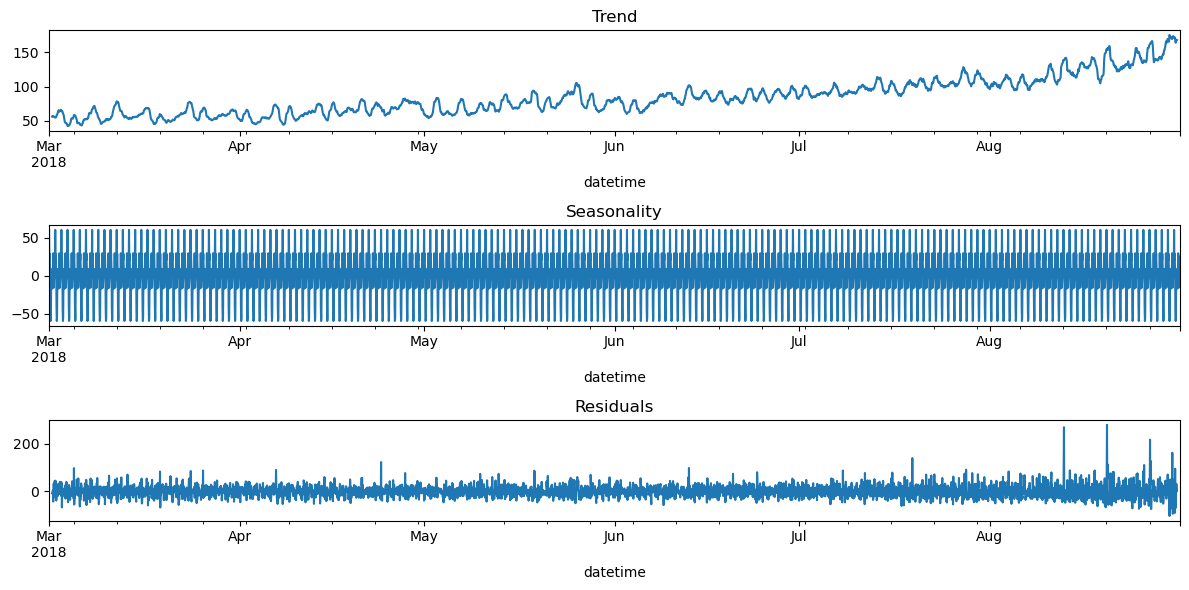

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [12]:
decomposed_week = seasonal_decompose(df['2018-03-01':'2018-03-07'])

Text(0.5, 1.0, 'Seasonality')

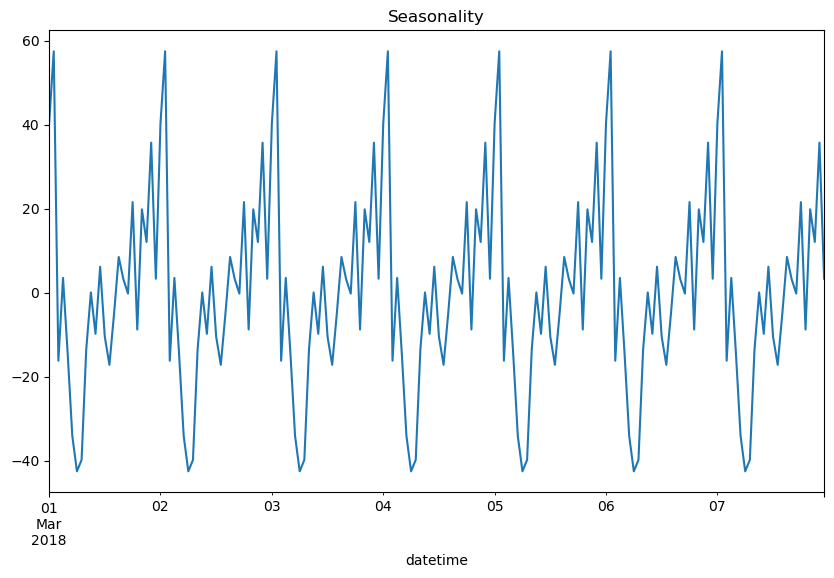

In [13]:
plt.figure(figsize=(10,6))
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


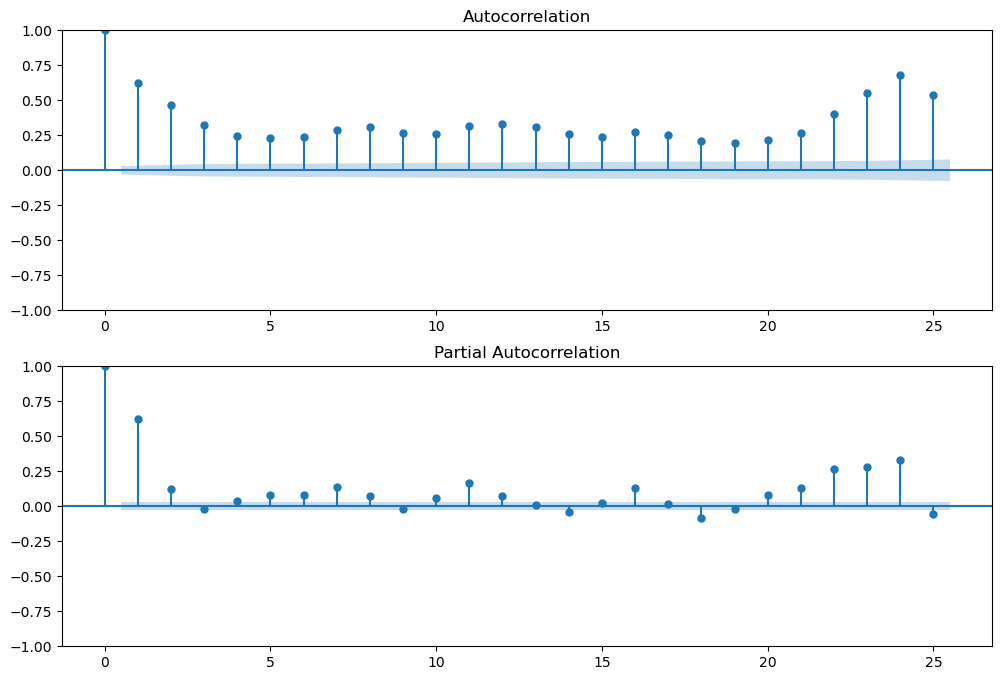

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = tsa.plot_acf(df.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = tsa.plot_pacf(df, lags=25, ax=ax2)

1. В данных прослеживается тренд на рост
1. Сезонность проявляется каждые сутки в значениях в час
1. На графике остатков видны пики в конце графика
1. На графике корреляции видна корреляция для значений 24 лагов

## Обучение

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean().shift()


1. Создадим функцию для создания признаков - лагов, скользящего среднего и дней, месяцев и дней недели

In [16]:
make_features(df, 24, 2)

1. Добавим признаки - 24 лага и скользящее среднее за 2 часа

In [17]:
df = df.dropna()

In [18]:
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,85.5
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,74.0
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,105.0
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,97.5
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,69.5


<AxesSubplot:xlabel='datetime'>

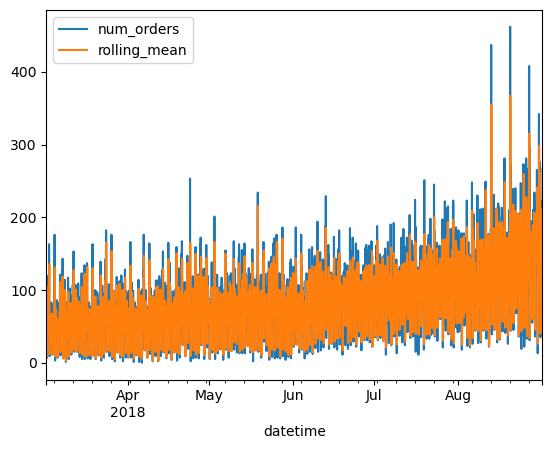

In [19]:
df.loc[:,('num_orders', 'rolling_mean')].plot()

1. График значений числа заказов и скользящего среднего

In [20]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']

In [21]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.1, shuffle=False)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3952, 27)
(440, 27)
(3952,)
(440,)


1. Разделим данные на тренировочную и тестовую выборки, тестовая выборка 10 %

In [22]:
def baseline_models(train, test):
        
    pred_median = np.ones(test.shape) * train.median()
    median_rmse = mean_squared_error(test, pred_median, squared=False)
    
    pred_previous = test.shift()
    pred_previous.iloc[0] = train.iloc[-1]

    previous_rmse = mean_squared_error(pred_previous, test, squared=False)
    
    return median_rmse, previous_rmse

In [23]:
print('RMSE median = %f, RMSE previous = %f' % (baseline_models(target_train, target_test)))

RMSE median = 87.210938, RMSE previous = 58.881777


1. Значения RMSE для предсказания с помощью среднего и прогнозированием предыдущим значеним больше требуемого
1. RMSE предсказания предыдущим значнеием 59 что достаточно близко к требуемому значению RMSE = 48

In [24]:
tscv = TimeSeriesSplit()

1. Для оценки моделей и подобра гиперпараметров воспользуюемя кросс-валидацией для временных рядов 

**Модель LinearRegression**

In [25]:
model = LinearRegression()

In [26]:
cv_scores = cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')

In [27]:
model.fit(features_train, target_train)
rmse_regular = mean_squared_error(target_train, model.predict(features_train), squared=False)

In [28]:
print('средняя RMSE на модели LinearRegression = %f,' % np.mean(-cv_scores), 'RMSE на тестовой выборке = %f' % rmse_regular)

средняя RMSE на модели LinearRegression = 27.198277, RMSE на тестовой выборке = 25.844766


**Модель CatBoostRegressor**

In [29]:
model = CatBoostRegressor(random_state=42, verbose=False)

In [30]:
parameters = {'depth' : [1,6,10],
              'learning_rate' : [0.5, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              }
grid = GridSearchCV(model, parameters, scoring='neg_root_mean_squared_error', cv=tscv)
grid.fit(features_train, target_train)

model.fit(features_train,target_train)

cbr_tuned = grid.best_estimator_

cbr_rmse_tuned = grid.best_params_
cbr_rmse_regular = mean_squared_error(target_train, model.predict(features_train), squared=False)

In [31]:
cbr_rmse_tuned

{'depth': 6, 'iterations': 100, 'learning_rate': 0.1}

In [32]:
cv_scores = cross_val_score(cbr_tuned, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')

In [33]:
print('средняя RMSE на модели CatBoostRegressor = %f,' % np.mean(-cv_scores), 'RMSE на тренировочной выборке без подбора гиперпараметров = %f' % cbr_rmse_regular)

средняя RMSE на модели CatBoostRegressor = 24.671667, RMSE на тренировочной выборке без подбора гиперпараметров = 11.007023


**Модель LGBMRegressor**

In [34]:
model = LGBMRegressor(random_state=42)

In [35]:
parameters = {
    'num_leaves': [7, 14, 21],
    'learning_rate': [0.1, 0.03],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

grid = GridSearchCV(model, parameters, scoring='neg_root_mean_squared_error', cv=tscv)
grid.fit(features_train, target_train)

model.fit(features_train,target_train)

lgbm_tuned = grid.best_estimator_

lgbm_rmse_tuned = grid.best_params_
lgbm_rmse_regular = mean_squared_error(target_train, model.predict(features_train), squared=False)

In [36]:
lgbm_rmse_tuned

{'learning_rate': 0.03, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 7}

In [37]:
cv_scores = cross_val_score(lgbm_tuned, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')

In [38]:
print('средняя RMSE на модели LGBMRegressor = %f,' % np.mean(-cv_scores), 'RMSE на тренировочной выборке без подбора гиперпараметров = %f' % lgbm_rmse_regular)

средняя RMSE на модели LGBMRegressor = 24.384156, RMSE на тренировочной выборке без подбора гиперпараметров = 12.258314


1. Проведена оценка RMSE на кросс валидации и подбор гиперпараметров для моделей LinearRegression, CatBoostRegressor, LGBMRegressor
1. Все три модели показали результат удовлетворяющий требовнимя задачи RMSE меньше 48 - RMSE = 25-27

## Тестирование

1. Для тестирования возьмем модель CatBoostRegressor и обучи ее на тренировочной, гиперпараметры зададим определенные GridSearchCV

In [39]:
model = CatBoostRegressor(depth=6, iterations=100, learning_rate = 0.1, random_state=42, verbose=False)

In [40]:
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)

In [41]:
rmse_test = mean_squared_error(target_test, predicted_test, squared=False)
print('RMSE на тестовой выборке = %f' % rmse_test)

RMSE на тестовой выборке = 42.666278


In [42]:
pred_with_resid = decomposed.resid.loc[target_test.index]+predicted_test

In [43]:
predicted_test = pd.DataFrame(predicted_test, index=target_test.index)

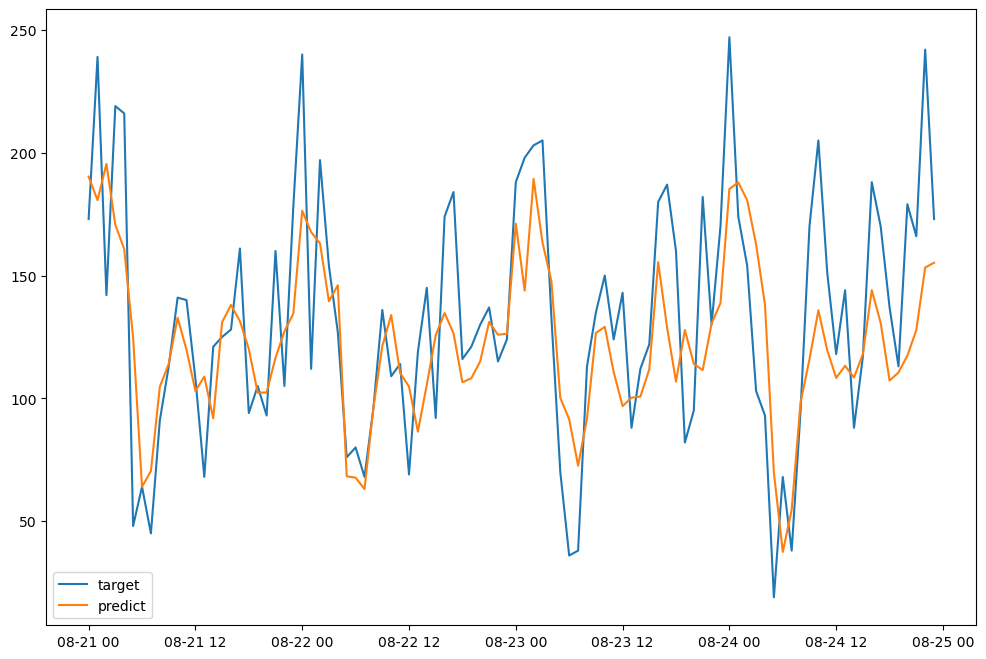

In [44]:
plt.figure(figsize=(12,8))
plt.plot(target_test.loc['2018-08-21':'2018-08-24'])
plt.plot(predicted_test.loc['2018-08-21':'2018-08-24'])
plt.legend(['target', 'predict'])

По графику видно что основные ошибки приходятся на участки с выбросами, так же этим участкам соответствует высокие значения 

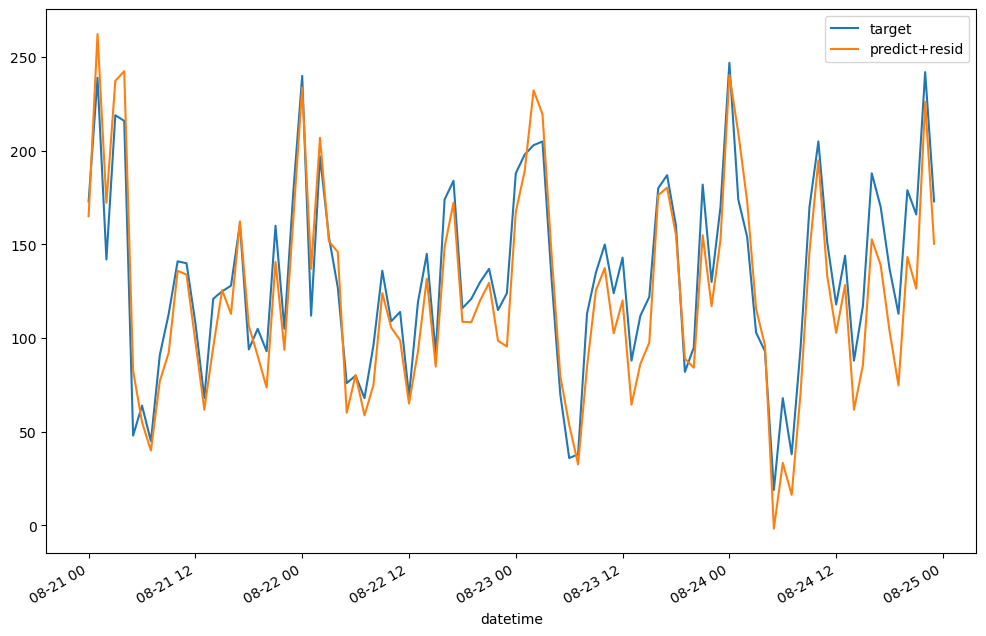

In [45]:
plt.figure(figsize=(12,8))
plt.plot(target_test.loc['2018-08-21':'2018-08-24'])
pred_with_resid.loc['2018-08-21':'2018-08-24'].plot(ax=plt.gca())
plt.legend(['target', 'predict+resid'])

На этом графике видим учаски, ошибка на которых была вызванна не шумом и что модель можно улучшить

**Вывод**

1. В данной работе была решена задача построения предсказания количества заказов такси в следующий час 

1. Загрузка и обработка данных:
      1. Для анализа и обучения модели были предоставленны исторические данные о заказах такси в аэропорт, данные представленны 26496 значениями числа заказов за 10 минут, с 2018-03-01 00:00:00 по 2018-08-31 23:50:00
      1. Исходя из условий задачи данные были ресмплированы по одному часу - итоговое количество значений составило 4416
      1. Значения в датафрейме расположены монотонно
      
1. Анализ данных:
    1. Для анализа из данных были разделены на составляющие: тренд, сезонность и остаток и построенны графики составлящих, которые показали что - в данных прослеживается тренд на рост, сезонность проявляется каждые сутки в значениях в час, на графике остатков видны пики в конце графика
    1. Для определения корреляци построим коррелограммы - на графике корреляции видна корреляция для значений 24 лагов 
    
1. Создание признаком и проверка моделей:
    1. Для создания признаков было написана функция добавляющаяя занчения месяца, дня и дня недели и значения скользящего среднего и лагов
    1. Для сравнения с выбранными моделями были получено значение RMSE при предсказании средним значением и предыдущим значением. При предсказании предыдущим значением RMSE равен 59
    1. Для обучения и сравнения были выбраны 3 модели - LinearRegression, CatBoostRegressor, LGBMRegressor
    1. Проведена оценка RMSE на кросс валидации и подбор гиперпараметров для моделей
    1. Все три модели показали результат удовлетворяющий требовнимя задачи RMSE меньше 48 - RMSE = 25-27
1. Тестирование:
    1. Для тестирования выборка была разделена на тренировочную и тестовую, размер тестовой выборки 10%
    1. Моделью для тестирования выбрана CatBoostRegressor
    1. Результаты RMSE на тестовой выборке = 43.214573 что удовлетворяет требовниям задачи RMSE не больше 48
    
    
Заключение: результаты и выводы полученные по итогам данной работы позволили спрогнозировать количество заказов в следующий час,  RMSE значений ниже требуемого порога, что должно помочь заказчику в привлечении водителей в периоды пиковой нагрузки.